# Trevor Dorn-Wallenstein
# 1/22/18
# Looking for outliers in color/magnitude space?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits, ascii
from glob import glob
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
import astropy.units as u

%matplotlib inline

In [15]:
phot_table = Table(ascii.read('../data/1_17_18/photometry/all_photometry.dat'))

member_hdu = fits.open('../info/cluster_members.fits')
spectr_hdu = fits.open('../info/spectro_targets.fits')

member_table = Table(member_hdu[1].data)
spectr_table = Table(spectr_hdu[1].data)

phot_coords = SkyCoord(phot_table['RA'],phot_table['Dec'],unit=(u.hourangle, u.deg))
member_coords = SkyCoord(member_table['RAJ2000']*u.deg,member_table['DEJ2000']*u.deg)
spec_coords = SkyCoord(spectr_table['RAJ2000']*u.deg,spectr_table['DEJ2000']*u.deg)

idx_red, d2d_red, d3d_red = member_coords[(member_table['SpT']<75)&(member_table['SpT']>=50)].match_to_catalog_sky(phot_coords)
idx_blue, d2d_blue, d3d_blue = member_coords[member_table['SpT'] <= 20].match_to_catalog_sky(phot_coords)
idx_spec, d2d_spec, d3d_spec = spec_coords.match_to_catalog_sky(phot_coords)

/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, oper)(other)
/Users/carina/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)


In [43]:
member_table.colnames

['Seq',
 'Phot',
 'Spec',
 'Mm',
 'RAJ2000',
 'DEJ2000',
 'SpT',
 'Vmag',
 'e_Vmag',
 'Icmag',
 'e_Icmag']

In [38]:
#Filter to just stars with match closer than 1"
red_idx = idx_red[d2d_red.arcsec <= 1.0]
blue_idx = idx_blue[d2d_blue.arcsec <= 1.0]
spec_idx = idx_spec[d2d_spec.arcsec <= 1.0]

mask = np.ones(len(phot_table),dtype=bool)
blue_mask = np.ones(len(phot_table),dtype=bool)
mask[spec_idx] = False
mask[red_idx] = False
blue_mask[blue_idx] = False

candidates = phot_table[mask]
cand_coords = SkyCoord(candidates['RA'],candidates['Dec'],unit=(u.hourangle, u.deg))
blue_candidates = phot_table[mask&~blue_mask]

In [41]:
idx_mem, d2d_mem, d3d_mem = cand_coords.match_to_catalog_sky(member_coords)

142

In [47]:
cand_V = member_table['Vmag'][idx_mem]
cand_Ic = member_table['Icmag'][idx_mem]

cand_where_phot = candidates[d2d_mem.arcsec <= 1.0]
V_where_phot = cand_V[d2d_mem.arcsec <= 1.0]
Ic_where_phot = cand_Ic[d2d_mem.arcsec <= 1.0]

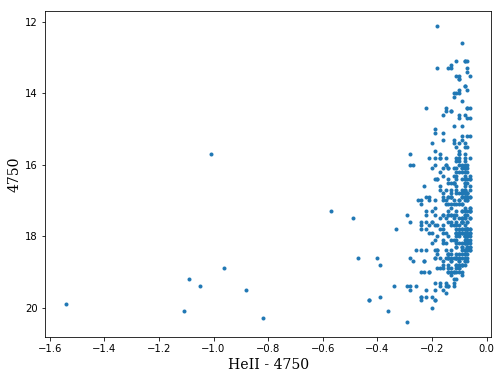

In [45]:
plt.figure(figsize=(8,6))
plt.scatter(phot_table['WN-CT'],phot_table['CT'],marker='.')
plt.gca().invert_yaxis()
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('4750',family='serif',fontsize=14)

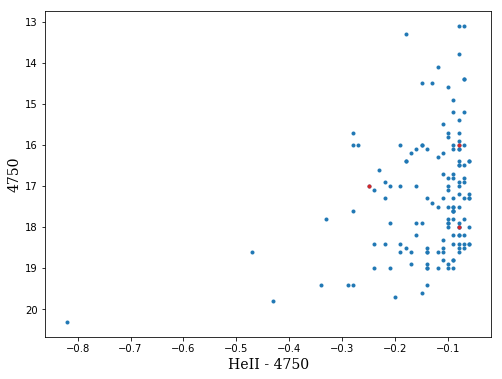

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(candidates['WN-CT'],candidates['CT'],marker='.')
plt.scatter(blue_candidates['WN-CT'],blue_candidates['CT'],marker='.',c='C3')
plt.gca().invert_yaxis()
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('4750',family='serif',fontsize=14)

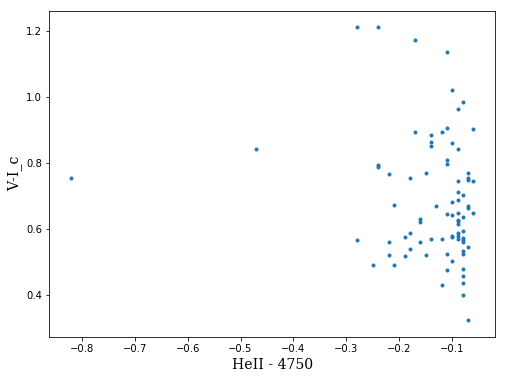

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(cand_where_phot['WN-CT'],V_where_phot-Ic_where_phot,c=marker='.')
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('V-I_c',family='serif',fontsize=14)

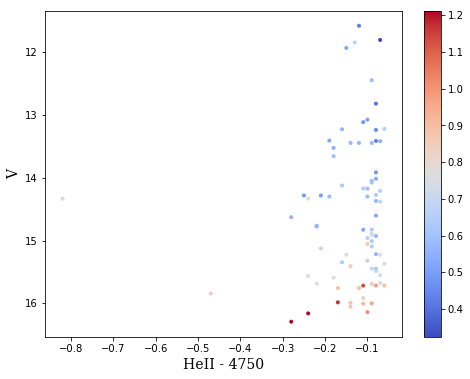

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(cand_where_phot['WN-CT'],V_where_phot,c=V_where_phot-Ic_where_phot,cmap='coolwarm',marker='.')
plt.gca().invert_yaxis()
plt.xlabel('HeII - 4750',family='serif',fontsize=14)
plt.ylabel('V',family='serif',fontsize=14)
plt.colorbar()

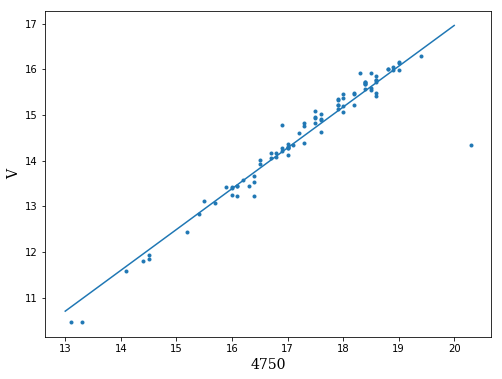

In [54]:
p = np.polyfit(cand_where_phot['CT'],V_where_phot,1)

plt.figure(figsize=(8,6))
plt.scatter(cand_where_phot['CT'],V_where_phot,marker='.')
x = np.linspace(13,20,100)
plt.plot(x,np.poly1d(p)(x))
plt.xlabel('4750',family='serif',fontsize=14)
plt.ylabel('V',family='serif',fontsize=14)

In [56]:
np.poly1d(p)(0)
#zeropoint is ~-1

-0.9144200448740226